# Predicting responstimes with a ReLU neural network - GUST with line search

In this notebook I evaluate the N-way RNN model trained with greedy unit-wise supervised pre-training using line search. 

### Findings
GUST-LS works well on the noise-free diamond:
 - in cc. 80% of the runs the MSE improved by 3 orders of magnitude or more, the median improvment being 6 orders of magnitude
 - the influential hyper-parameters seem to be the ones related to regularization, with $\gamma=4$ being a magic value

In [1]:
from pprint import pprint
from itertools import count
import theano
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from theano import pp
from theano import tensor as T
from theano import function
from theano.ifelse import ifelse
from theano.compile.nanguardmode import NanGuardMode
import numpy as np
from sklearn.model_selection import ParameterSampler
from scipy.stats.distributions import uniform, geom
from math import log, exp
import random
import operator
import sys
sys.setrecursionlimit(sys.getrecursionlimit()*5)

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
from FSBGraph import FSBSampler, FSBGraph, Trx

## Define the N-Way RNN model with the GUST-LS training algorithm

In [12]:
def createNWayRNNGUSTLineSearch(n, leaking_factor=0, oversizing=1):
    """ @param n: number of inputs to the RNN
        @param leaking_factor: slope of the ReLUs for the negative domain 
        @param oversizing: ratio of # of ReLUs to # of inputs
    """
    print "Creating NWayRNNGUSTLineSearch"
    assert n > 0
    m = n * oversizing
    
    def compute_MSE(m, U, W, X, y):
        # every row (selected by 0th coord) is an observation, 
        # fields in a row (1st coord) are input to the n ReLUs
        xU = T.dot(X, U)
        h = [T.nnet.relu( xU[:,0], alpha=leaking_factor )] #
        for t in range(1, m):
            input2relu = xU[:,t] + T.dot(T.stack(h[:t], axis=1), W[:t, t])
            h.append(T.nnet.relu(input2relu, alpha=leaking_factor)) 

        # The expected response time from the model:
        RT = h[-1]

        # residual:
        epsilon = y - RT.T

        # Mean squared error
        MSE = 0.5 * T.pow(epsilon, 2).mean() 

        return RT, epsilon, MSE, xU
        
    class NWayRNNGUSTLineSearch(object):
        leak = leaking_factor
        
        # every row (selected by 0th coord) is an observation, 
        # fields in a row (1st coord) are child trx resp time in the observation
        X = T.dmatrix('X')  

        # Actual parent resp time, each observation on a separate row
        y = T.dvector('y')

        # input-to-ReLU connections
        # row i contains the weights through which input i feeds into the ReLUs
        # column j stores the weights through which the inputs feed into unit j
        U = theano.shared(np.zeros((n, m)), 'U')
        
        # inter-ReLU connections, 
        # row i contains the weights through which unit i feeds into higher order units
        # column j stores the weights through which lower order units feed into unit j
        W = theano.shared(np.zeros((m, m)), 'W')
        
        # all the params adjusted during optimisation
        params = [U, W]
        u_shape = (n, m)
        w_shape = (m, m)
        shapes = [u_shape, w_shape]
        
        RT, epsilon, MSE, xU = compute_MSE(m, U, W, X, y)
        

        
        
        ### REGULARIZATION ###
        
        # Most elements of W and U should be 0, so we apply LASSO on them:
        l1 = T.dscalar('lambda1')  # regularization parameter for Lasso
        L1 = T.sum(abs(U)) + T.sum(abs(W))
        
        # We train in m stages, quasi 'ReLU-wise', so we need 2 kinds of parameters:
        # - a prior estimate for the values of the sought variables, i.e. U and W 
        U0 = theano.shared(np.zeros((n, m)), 'U0')
        W0 = theano.shared(np.zeros((n, m)), 'W0')
        
        # - a regularization strength for the inputs feeding into the m ReLUs, i.e. for each column of U
        l_u = theano.shared(np.ones((m, )), 'l')    
        
        # - a regularization strength for the cross-feed of the m ReLUs, i.e. for each cell of W
        l_w = theano.shared(np.ones((m, )), 'l')    
        
        # overall regularization strength for ReLU-wise training
        l2u = T.dscalar('lambda2u')  
        l2w = T.dscalar('lambda2w')  

        dU = U - U0;   dU2 = dU * dU;   L2u = T.dot(  dU2           , l_u).sum() 
        dW = W - W0;   dW2 = dW * dW;   L2w = T.dot( T.dot(l_w, dW2), l_w).sum()
        
        # the cost function
        E = MSE + l1*L1 + L2u*l2u + L2w*l2w
        
        # the gradients:
        gradient_E_U = T.grad(E, U)
        gradient_E_W = T.grad(E, W)

        
        ##############################################
        ######## update_directions function ##########
        direction_U, direction_W = [theano.shared(np.zeros(shape)) 
                                      for param, shape in zip(params, shapes)]
                
        momentum = T.dscalar('momentum')
        
        direction_U_update = (direction_U, momentum * direction_U - gradient_E_U )
        direction_W_update = (direction_W, momentum * direction_W - gradient_E_W )
        direction_updates = [ direction_U_update, direction_W_update]
        
        training_result_variables = ('RT', 'epsilon', 'MSE', 'E',)
        update_directions = staticmethod(theano.function(
                  inputs  = [X, y, momentum, l1, l2u, l2w, ],
                  outputs = [RT, epsilon, MSE, E],
                  updates = direction_updates,
                  mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
                    ))
        
        ##########################################
        ######## try_step_size function ##########
        step_size = T.dscalar('step_size')
        new_U = U + step_size * direction_U
        new_W = W + step_size * direction_W
        new_params = new_U, new_W 
        
        try_step_size = staticmethod(theano.function(
                  inputs  = [step_size, X, y],
                  outputs = new_params + compute_MSE(m, new_U, new_W, X, y),  #  RT, epsilon, MSE, xU,
                  # mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
                    ))
        
        selected_U = T.dmatrix('selected_U')  
        selected_W = T.dmatrix('selected_W')  

        ##########################################
        ######## update_params function ##########
        update_params = staticmethod(theano.function(
                  inputs = [selected_U, selected_W],
                  outputs = [],
                  updates = [(U, selected_U), (W, selected_W)]
                    ))
        
        prediction_result_variables = 'RT', 'epsilon', 'MSE'
        predict = staticmethod(theano.function(inputs=[X, y], 
                                               outputs=[RT, epsilon, MSE] ))


        #####################################
        ####### Prediction function #########

        prediction_result_variables = 'RT', 'epsilon', 'MSE', 'xU'
        predict = staticmethod(theano.function(inputs=[X, y], 
                                               outputs=[RT, epsilon, MSE]))

        #####################################
        ###### Stage update functions ########
        
        # the stage we start or finish (numbered starting -1 to -m)
        j = T.iscalar('j')  
        
        # The regularization weight for the ReLU being trained
        l_j = T.dscalar('l_j')
        
        # Increase the above weight by this factor in every subsequent stage
        gamma = T.dscalar('gamma')
        
        # the value to initialize the new column of U from
        U_init = T.dmatrix('U_init')
        
        # the value to initialize the new column of W from
        W_init = T.dmatrix('W_init')

        # run this function before every stage
        init_stage = staticmethod(theano.function(
                inputs = [j, U_init, W_init], 
                updates = [(U  , T.set_subtensor(U  [:, j ], U_init[:, j ]) ),  # init column j
                           (W  , T.set_subtensor(W  [j, j:], W_init[j, j:]) ),  # init row j above the diagonal
                           (l_u, T.set_subtensor(l_u[j    ], 1            ) ),
                           (l_w, T.set_subtensor(l_w[j    ], 1            ) ),
                          ]
            ))
        
        # run this function after every stage
        finish_stage = staticmethod(theano.function(
                inputs = [j, gamma], 
                updates = [(U0 , T.set_subtensor(U0 [ :, j:], U  [ :, j:]) ),  # copy last j columns
                           (W0 , T.set_subtensor(W0 [j:, j:], W  [j:, j:]) ),  # copy j x j sub-matrix
                           (l_u, T.set_subtensor(l_u[j:], l_u[j:] *        gamma ) ),
                           (l_w, T.set_subtensor(l_w[j:], l_w[j:] * T.sqrt(gamma)) ),
                           ]
            ))
            
        def stages(self, U_init, W_init, gamma):
            """ Iterate through the stages, setting the regularization parameters
            """
            n, m = self.u_shape
            bigNum = 1e8   # a very big value, for very strong regularization
            gamma = np.exp(min(np.log(gamma), np.log(bigNum)/m))
            self.l_u.set_value(np.ones((m,)) * bigNum)
            self.l_w.set_value(np.ones((m,)) * np.sqrt(bigNum))
            
            for j in range(-1, -m-1, -1):
                self.init_stage(j, U_init, W_init)
                yield j
                self.finish_stage(j, gamma)        
                           
        # Code taken from https://en.wikipedia.org/wiki/Golden-section_search
        golden_ratio = (np.sqrt(5) + 1) / 2
        
        def find_step_size(self, a, b, X, y, orig_MSE, tolerance):            
            c = b - (b - a) / self.golden_ratio
            d = a + (b - a) / self.golden_ratio
            limit = tolerance  # (b - a) * tolerance

            while abs(c - d) > limit:
#                 print a, c, d, b, np.exp(a), np.exp(b)
                # new_U, new_W, RT, epsilon, MSE, xU 
                c_MSE = self.try_step_size(np.exp(c), X, y)[4]
                d_MSE = self.try_step_size(np.exp(d), X, y)[4]
                
                if c_MSE < d_MSE or np.isnan(c_MSE) or np.isnan(d_MSE) or max(c_MSE, d_MSE) > orig_MSE:
                    b = d
                else:
                    a = c

                c = b - (b - a) / self.golden_ratio
                d = a + (b - a) / self.golden_ratio

            step_size = np.exp((b + a) / 2 )
            # new_U, new_W, RT, epsilon, MSE, xU                
            return self.try_step_size(step_size, X, y), step_size

        def record_results(self, **kwargs):
            for k, v in kwargs.items():
                k = k + 's'
                getattr(self, k).append(v)

        def __init__(self, log_step_size_min, log_step_size_max, log_tolerance, 
                     log_lower_bound_ratio, log_upper_bound_ratio,
                     momentum, l1, gamma, l2u, l2w, grace_period, MSE_limit, ):
            assert 0.0 <= momentum < 1.0
            self.        step_size_min,        self.step_size_max = \
              np.exp(log_step_size_min), np.exp(log_step_size_max)
                                                
            self.momentum, self.grace_period ,  self.MSE_limit,       self.tolerance, = \
                 momentum,  int(grace_period),       MSE_limit, np.exp(log_tolerance), 
                                                
            self.        lower_bound_ratio ,       self.upper_bound_ratio = \
              np.exp(log_lower_bound_ratio), np.exp(log_upper_bound_ratio)

            self.l1, self.gamma, self.l2u, self.l2w, = \
                 l1,      gamma,      l2u,      l2w, 

        def do_train(self, data, batch_size, rng):
            if verbose:
                print ("Training the model using the following parameters:"
                       "\nstep_size = {},\tlambda1 = {},\tgamma = {}, \tlambda2u = {},"
                       "\tlambda2w = {}" \
                        .format(self.step_size, self.l1, self.gamma, self.l2u, self.l2w))
                           
                print ("\nleak={:9.7f}"
                       "\nmomentum = {:9.7f}\tgrace_period = {:9.7f}" \
                        .format(self.leak, self.momentum, self.grace_period))
                print ("tolerance = {:9.7f},\tlower_bound_ratio = {:9.7f}\tupper_bound_ratio = {:9.7f}" \
                        .format(self.tolerance, self.lower_bound_ratio, self.upper_bound_ratio))
            
            self.bestMSE = 1e128
            
            self.MSEs = list()
            self.step_sizes = list()
            self.stage_ends = list()

            self.U .set_value(np.zeros(self.u_shape))
            self.W .set_value(np.zeros(self.w_shape))

            self.U0.set_value(np.zeros(self.u_shape))
            self.W0.set_value(np.zeros(self.w_shape))
            
            U_init = ( rng.uniform(low=-1, high=1, size=self.u_shape) * 1e-4)
            W_init = ( rng.uniform(low=-1, high=1, size=self.w_shape)
                                     * (np.ones(self.w_shape) - np.tri(*self.w_shape)) * 1e-1
                                     )

            self.MSEs = list()
            for j in self.stages(U_init, W_init, gamma=self.gamma):
                if verbose:
                    print
                    print '*'*10, 'Stage #{}'.format(-j), '*'*10
                    print 'Regularization weight vectors for U and W:'
                    print self.l_u.get_value() * self.l2u
                    print self.l_w.get_value() * self.l2w
                    print 'Before training:'
                    for param in self.params:
                        print param.get_value()
                    print 'Priors:'
                    print self.U0.get_value()
                    print self.W0.get_value()
                
                a = np.log(self.step_size_min)
                b = np.log(self.step_size_max)
                steps = count(0)
                grace_counter = reversed(xrange(self.grace_period))
                while next(grace_counter):
                    i = next(steps)
                    #########
                    train_X_samples, train_RT_samples = data.sample(batch_size)
                    result = self.update_directions(
                                        train_X_samples, train_RT_samples, 
                                        self.momentum, lambda1=self.l1, lambda2u=self.l2u, lambda2w=self.l2w) 
                    RT, epsilon, MSE, E, = result
                           
                    (new_U, new_W, _RT, _epsilon, _MSE, xU), step_size = \
                                self.find_step_size(a, b, train_X_samples, train_RT_samples, MSE, self.tolerance)
                           
                    a = np.log( step_size *self.lower_bound_ratio) 
                    b = np.log( step_size *self.upper_bound_ratio) 

                    self.update_params(new_U, new_W)

                    self.record_results(MSE=MSE, 
                                        step_size=step_size,
                                       )
                           
                    if verbose and MSE < self.bestMSE:
                        print ("Batch #{}: Cost={}, "
                               "MSE={}"
                                .format(i, float(E), float(MSE), ))
                    else:
                        pass #print '{:5.3f}'.format(float(MSE)),
                    if MSE < self.bestMSE:
                        self.bestMSE = MSE
                        grace_counter = reversed(xrange(self.grace_period))
                    if MSE < self.MSE_limit:
                        break
                        
                self.stage_ends.append(len(self.MSEs))
                
                if verbose:
                    print 'After training:'
                    for param in self.params:
                        print param.get_value()

            self.training_results = dict(zip(self.training_result_variables, result))                
            self.training_results['training_steps'] = self.training_steps = i
            
            (self.training_results['validation_RT'], 
             self.training_results['validation_epsilon'], 
             self.training_results['validation_MSE']) = self.predict(data.validation_X_samples, 
                                                                     data.validation_RT_samples)                
            
            print "Nbr of training steps = {} \tBest training MSE = {} \tValidation MSE = {}"\
                        .format(len(self.MSEs)+1, self.bestMSE, self.training_results['validation_MSE'])

            if verbose:
                print "Validation MSE = {}".format(self.training_results['validation_MSE'])
#                 print "Batch #{}: lambda={:7.5f}, Cost={:7.5f}, Training MSE={:7.5f}\nWeights:"\
#                         .format(i, float(l_), float(E), float(MSE))
                for param in self.params:
                    print param.get_value()


        def __call__(self, data):
            prediction_result = self.predict(data.test_X_samples, data.test_RT_samples)
            return dict(zip(self.prediction_result_variables, prediction_result))

    print "Created NWayRNNGUSTLineSearch"
    return NWayRNNGUSTLineSearch


In [102]:
verbose=True

In [4]:
def plotMSEvsIteration(rnn):
    plt.figure(figsize=(15, 5))
    plt.title('MSE vs. # of iterations')
    plt.grid(which='both')
    plt.minorticks_on()

    prev_stage_end = 0
    for j in range(len(rnn.stage_ends)):
        plt.plot(range(prev_stage_end, rnn.stage_ends[j]), 
                 rnn.MSEs[prev_stage_end : rnn.stage_ends[j]],)
        prev_stage_end = rnn.stage_ends[j]

    plt.yscale('log')
    plt.show()

## Initial test of the algorithm on the diamond structure

In [115]:
%%time
class Diamond(object):
    
    # alpha=-100, beta=0.0 ensure the child response times do not contain
    # additive noise
    graph = FSBGraph()
    graph.add_edge('start', 'B1', alpha=-100, beta=0.0)
    graph.add_edge('start', 'B2', alpha=-100, beta=0.0)
    graph.add_edge('B1', 'end', alpha=-100, beta=0.0)
    graph.add_edge('B2', 'end', alpha=-100, beta=0.0)
    graph.add_edge('B1', 'B2', alpha=-100, beta=0.0)

    #graph.start_node, graph.end_node = graph.nodes['start'], graph.nodes['end']
    graph.start_node, graph.end_node = 'start', 'end'
    data = FSBSampler(graph, num_children=5, training_set_size=5000, validation_set_size=5000, )
    RNN = createNWayRNNGUSTLineSearch(5, leaking_factor=-1.0, oversizing=1)
    rnn = RNN(momentum=0.9, 
              l1=1e-3, 
              gamma=4.0, 
              l2u=1e-6, 
              l2w=1e-5, 
              grace_period=100, 
              MSE_limit=1e-8, 
              log_step_size_min     = -7, 
              log_step_size_max     = 1, 
              log_tolerance         = -3, 
              log_lower_bound_ratio = -3, 
              log_upper_bound_ratio = +2,
             )
    rnn.do_train(data=data, batch_size=128, rng=np.random.RandomState(1235), )    

Generating 5000 training, 5000 validation and 0 test samples
Creating NWayRNNGUSTLineSearch
Created NWayRNNGUSTLineSearch
Training the model using the following parameters:
step_size = step_size,	lambda1 = 0.001,	gamma = 4.0, 	lambda2u = 1e-06,	lambda2w = 1e-05

leak=-1.0000000
momentum = 0.9000000	grace_period = 100.0000000
tolerance = 0.0497871,	lower_bound_ratio = 0.0497871	upper_bound_ratio = 7.3890561

********** Stage #1 **********
Regularization weight vectors for U and W:
[ 100.  100.  100.  100.    0.]
[ 0.1  0.1  0.1  0.1  0. ]
Before training:
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Priors:
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0. 

The model could be trained to achieve very low MSE values.

The below plot shows the evolution of the MSE throughout the training procedure (the different colours correspond to the different GUST stages).

In the initial stages (stage 1 & 2) the model is short on representational capacity and the MSE does not improve. These stages are still important for the proper positioning of the parameter vector for the next stage(s).  When the required capacity is reached (stage 3) the MSE starts to improve rapidly.

From the printed parameter tensors one can see that stage 4 and 5 are not necessary: 3 ReLUs are sufficient to represent the diamond. In these stages the RNN has representation capacity in excess but the regularization keeps the parameters within bounds. The algorithm used the iterations to reduce the MSE by refining the parameters of the first three units. 

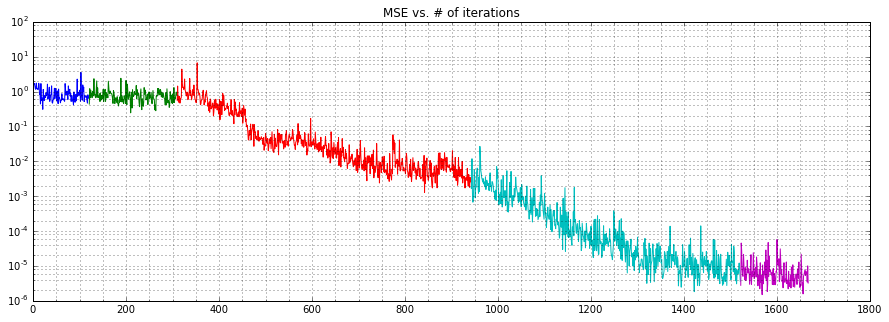

In [116]:
plotMSEvsIteration(Diamond.rnn)

## Are these results reproducible?
The GUST-LS algorithm is based on SGD, therefore it is not deterministic. Are the results obtained above reliably reproducible? With random sampling from the same training set, all other hyper parameters and the initialization of the search vector being equal, what is the chance that the training "succeeds"?

In [5]:
graph = FSBGraph()
graph.add_edge('start', 'B1', alpha=-100, beta=0.0)
graph.add_edge('start', 'B2', alpha=-100, beta=0.0)
graph.add_edge('B1', 'end', alpha=-100, beta=0.0)
graph.add_edge('B2', 'end', alpha=-100, beta=0.0)
graph.add_edge('B1', 'B2', alpha=-100, beta=0.0)
graph.start_node, graph.end_node = 'start', 'end'

In [6]:
def plotRuns():
    plt.figure(figsize=(7, 7))
    plt.title('Validation MSE vs. Number of iterations')
    plt.grid(which='both')
    plt.minorticks_on()
    x = [len(rnn.MSEs) for rnn in models]
    y = [float(rnn.training_results['validation_MSE']) for rnn in models]
    plt.scatter(x, y, c='red')
    plt.yscale('log')
    plt.ylim(min(y)/10, max(y)*10)
#     plt.xlim(-.5, len(x)+.5)
    plt.xlabel("Iterations")
    plt.ylabel("Validation MSE")
    plt.show()

In [7]:
def createModelsSameConstellation(graph, num_models=50, seed=None, **paramsetting):
    bad_models = list()
    models = list()
    data = FSBSampler(graph, num_children=graph.num_children, 
                      training_set_size=5000, validation_set_size=5000, test_set_size=5000)
    for c in range(num_models):
        print "\n= Model #{} =".format(c)
        RNN = createNWayRNNGUSTLineSearch(5, leaking_factor=-1.0, oversizing=1)
        rnn = RNN(**paramsetting)
        try:
            rnn.do_train(data=data, batch_size=128, rng=np.random.RandomState(seed), )
        except AssertionError as e:
            print "!!! NAN !!!"
            bad_models.append (rnn)
        else:
            models.append(rnn)
    return models, bad_models            

In [120]:
%%time
verbose = False
models, bad_models = createModelsSameConstellation(graph, 
                                                   num_models=50,
                                                   momentum=0.9, 
                                                   l1=1e-3, 
                                                   gamma=4.0, 
                                                   l2u=1e-6, 
                                                   l2w=1e-5, 
                                                   grace_period=100, 
                                                   MSE_limit=1e-8, 
                                                   log_step_size_min     = -7, 
                                                   log_step_size_max     = 1, 
                                                   log_tolerance         = -3, 
                                                   log_lower_bound_ratio = -3, 
                                                   log_upper_bound_ratio = +2,
                                                   )

Generating 5000 training, 5000 validation and 5000 test samples

= Model #0 =
Creating NWayRNNGUSTLineSearch
Created NWayRNNGUSTLineSearch
Nbr of training steps = 943 	Best training MSE = 0.0950684074179 	Validation MSE = 0.282805198945

= Model #1 =
Creating NWayRNNGUSTLineSearch
Created NWayRNNGUSTLineSearch
Nbr of training steps = 1586 	Best training MSE = 2.59548297955e-06 	Validation MSE = 1.18039424843e-05

= Model #2 =
Creating NWayRNNGUSTLineSearch
Created NWayRNNGUSTLineSearch
Nbr of training steps = 1770 	Best training MSE = 1.09666553526e-06 	Validation MSE = 4.97592241309e-06

= Model #3 =
Creating NWayRNNGUSTLineSearch
Created NWayRNNGUSTLineSearch
Nbr of training steps = 818 	Best training MSE = 0.0900505539669 	Validation MSE = 0.198013094649

= Model #4 =
Creating NWayRNNGUSTLineSearch
Created NWayRNNGUSTLineSearch
Nbr of training steps = 1487 	Best training MSE = 8.48518207477e-07 	Validation MSE = 1.8115484668e-06

= Model #5 =
Creating NWayRNNGUSTLineSearch
Created N

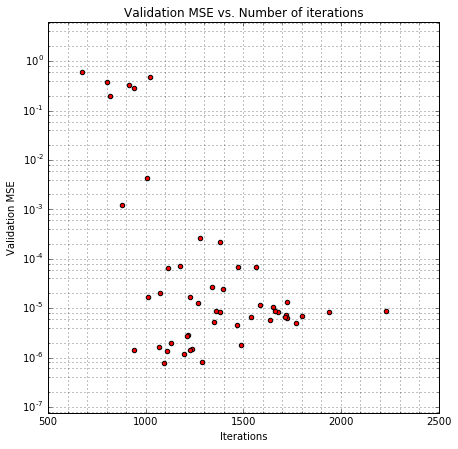

In [121]:
plotRuns()

In the median case the MSE was decreased by 6 or more orders of magnitude. In 84% of the cases it was improved by 3 orders of magnitud or more and in 88% of the cases it was improved by at least 2 orders of magnitude.

The take-away from this experiment is that the algorithm relatively insensitive to the non-determinism introduced by the random sampling of the training set.

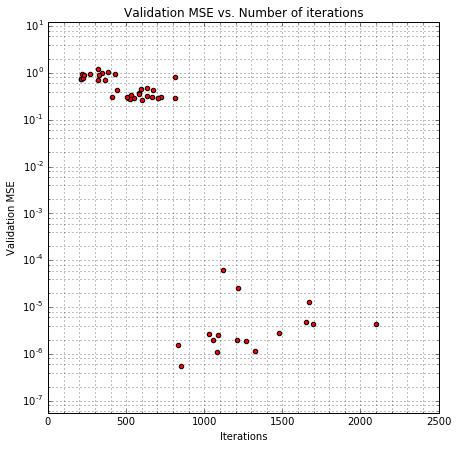

In [117]:
# The below plot was created so that the jth ReLU added was not "accepted" by the training
# (i.e. it did not feed into any earlier added unit after the training), the training was stopped.
# To achieve this, the stage() method was modified as:
    
#         def stages(self, U_init, W_init, gamma):
#             """ Iterate through the stages, setting the regularization parameters
#             """
#             n, m = self.u_shape
#             bigNum = 1e8   # a very big value, for very strong regularization
#             gamma = np.exp(min(np.log(gamma), np.log(bigNum)/m))
#             self.l_u.set_value(np.ones((m,)) * bigNum)
#             self.l_w.set_value(np.ones((m,)) * np.sqrt(bigNum))
            
#             for j in range(-1, -m-1, -1):
#                 self.init_stage(j, U_init, W_init)
#                 yield j
#                 self.finish_stage(j, gamma)
#                 if j < -1 and abs(self.W.get_value()[:, j+1]).sum() < -0.05:
#                     break
    
plotRuns()

# One can see the effexct of this early exit: most runs complete early (the 50 training runs took 1h 15min)
# but a lot smaller number of runs converged. Not "accepting" the ReLU in the stage when it is added
# does not mean the training will not succeed: some later stages may accept it together with other units.

In [122]:
del models[:]

## Which hyper parameters are the most influential?
From the previous experiment we saw that the algorithm is relatively insensitive to the non-determinism of SGD. This means that if runs with varying hyper-parameter values produce varying training results, those are likely to be rooted in the chosen hyper-parameter constellation. This gives hope that we can identify the hyper-parameters with high impact on the algorithm.

We analyse this by a random search in the hyper-parameter space.

In [13]:
def uniform_from_to(a, b):
    return uniform(a, b-a)

def log_uniform_from_to(a, b):
    a, b = log(a), log(b)
    
    class C(object):
        def rvs(self, *args, **kwargs):
            return exp(uniform(a, b-a).rvs(*args, **kwargs))
        
    return C()

distributions = dict(log_step_size_min     = uniform_from_to(log(1e-7),  log(1e-5)), 
                     log_step_size_max     = uniform_from_to(log(1e-2),  log(1e0)), 
                     log_tolerance         = uniform_from_to(log(1e-4),  log(1e-2)), 
                     log_lower_bound_ratio = uniform_from_to(log(1e-3),  log(1e0)), 
                     log_upper_bound_ratio = uniform_from_to(log(1e0),  log(1e2)),
                     momentum              = uniform_from_to(0,  1), 
                     l1                    = log_uniform_from_to(1e-7,  1e2), 
                     gamma                 = log_uniform_from_to(1,  10), 
                     l2u                   = log_uniform_from_to(1e-7,  1e2), 
                     l2w                   = log_uniform_from_to(1e-7,  1e2), 
                     grace_period          = uniform_from_to(50,  500), 
                    )

def createModels(graph, distributions, leak_func=lambda : -1.0, num_models=50):
    bad_models = list()
    models = list()
    data = FSBSampler(graph, num_children=graph.num_children, 
                      training_set_size=5000, validation_set_size=5000, test_set_size=5000)
    settings = ParameterSampler(  distributions, num_models)
    c = count(0)
    for paramsetting in settings:
        print "\n= Model #{} =".format(c.next())
        RNN = createNWayRNNGUSTLineSearch(graph.num_children, leaking_factor=leak_func(), oversizing=1)
        rnn = RNN(MSE_limit=1e-8, **paramsetting)
        try:
            rnn.do_train(data=data, batch_size=128, rng=np.random.RandomState(), )
        except AssertionError as e:
            print "!!! NAN !!!"
            bad_models.append (rnn)
        else:
            models.append(rnn)
    return models, bad_models

In [14]:
%%time
verbose = False
models, bad_models = createModels(graph, distributions, num_models=50)

Generating 5000 training, 5000 validation and 5000 test samples

= Model #0 =
Creating NWayRNNGUSTLineSearch
Created NWayRNNGUSTLineSearch
Nbr of training steps = 2433 	Best training MSE = 0.267089853406 	Validation MSE = 8.43744992549

= Model #1 =
Creating NWayRNNGUSTLineSearch
Created NWayRNNGUSTLineSearch
Nbr of training steps = 2165 	Best training MSE = 0.227082059617 	Validation MSE = 0.749738646394

= Model #2 =
Creating NWayRNNGUSTLineSearch
Created NWayRNNGUSTLineSearch
Nbr of training steps = 3064 	Best training MSE = 0.0133573298784 	Validation MSE = 0.0266194270947

= Model #3 =
Creating NWayRNNGUSTLineSearch
Created NWayRNNGUSTLineSearch
Nbr of training steps = 2762 	Best training MSE = 7.57825576891e-09 	Validation MSE = 3.24543105309e-08

= Model #4 =
Creating NWayRNNGUSTLineSearch
Created NWayRNNGUSTLineSearch
Nbr of training steps = 3717 	Best training MSE = 0.111273814456 	Validation MSE = 0.337862682009

= Model #5 =
Creating NWayRNNGUSTLineSearch
Created NWayRNNGUST

Let's plot the MSE of the training runs vs. the various hyper-parameters.

In [15]:
def plotMSEvsHyperParam(xparam, log=True):
    yparam = 'validation_MSE'
    plt.figure(figsize=(15, 5))
    plt.title(yparam + ' vs. ' + xparam)
    plt.grid(which='both')
    plt.minorticks_on()
    x = [float(getattr(rnn, xparam)) for rnn in models]
    y = [float(rnn.training_results[yparam]) for rnn in models]
    plt.scatter(x, y, c='red')
    
    if log:
        plt.xscale('log')
        plt.xlim(min(x)/10, max(x)*10)
        
    plt.yscale('log')
    plt.ylim(min(y)/10, max(y)*10)
    plt.xlabel(xparam)
    plt.ylabel(yparam)
    plt.show()

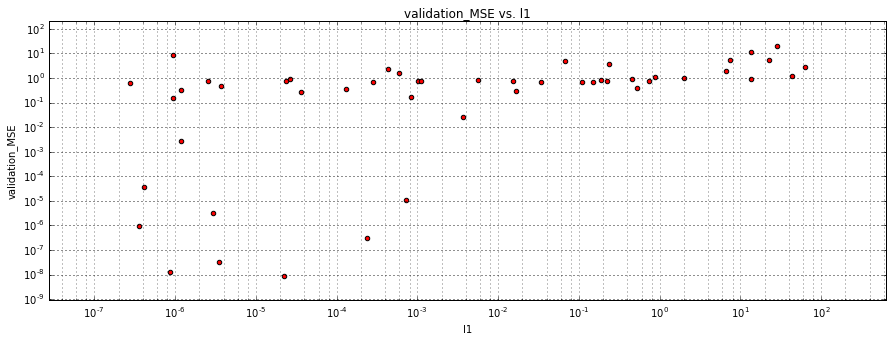

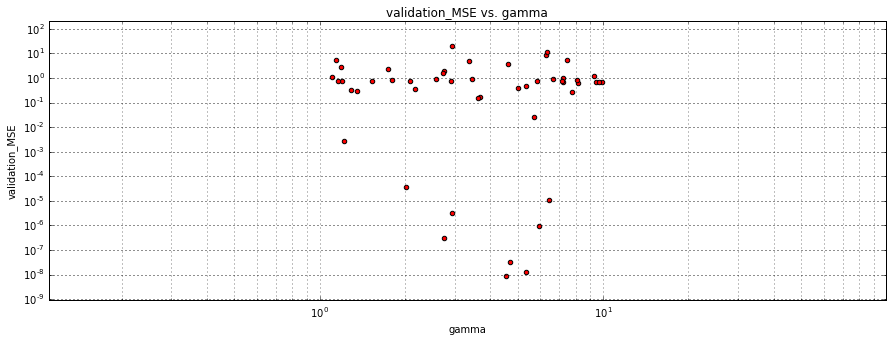

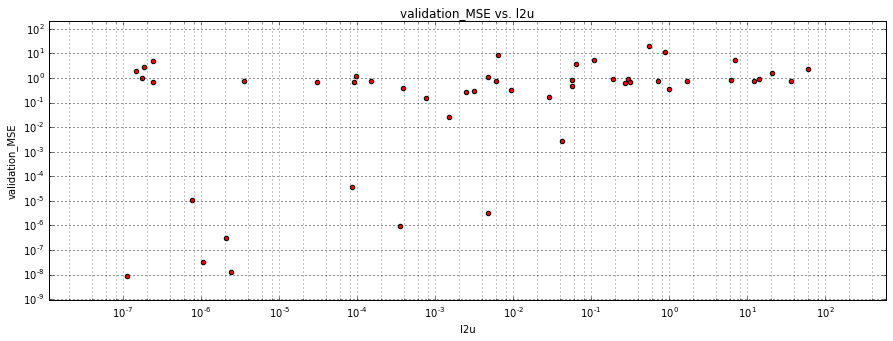

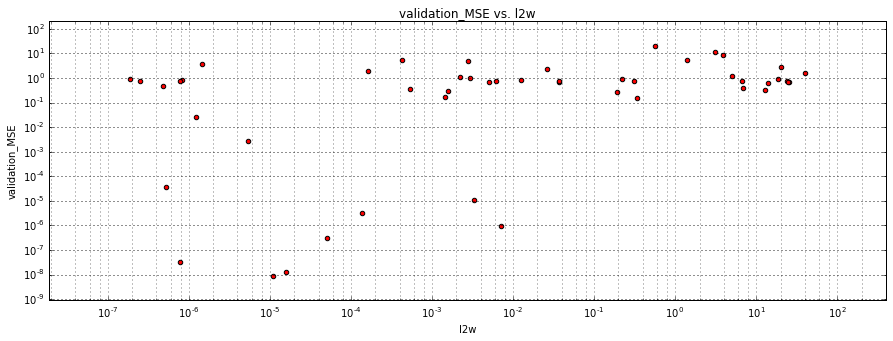

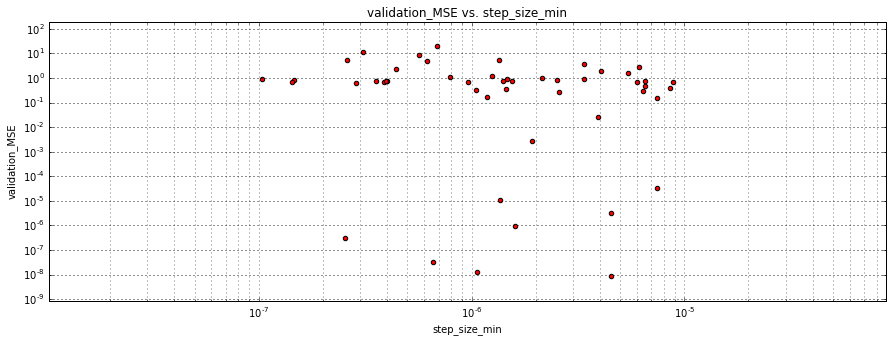

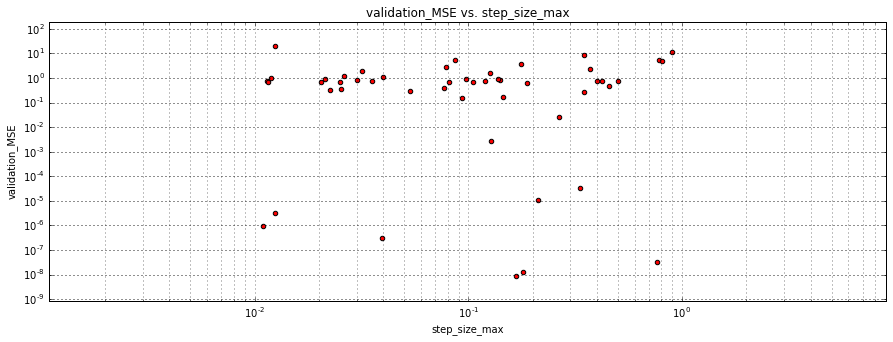

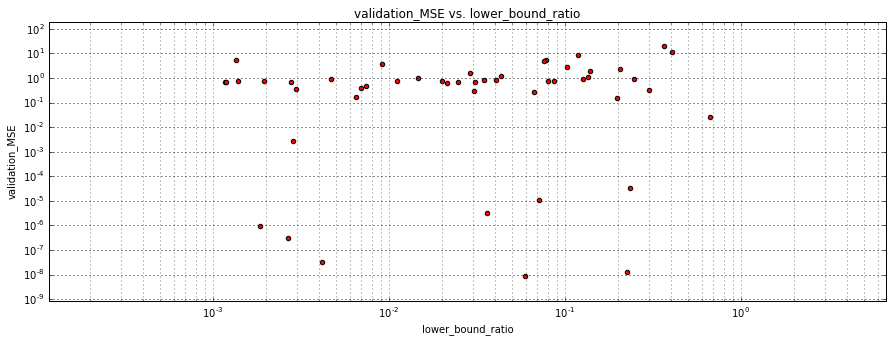

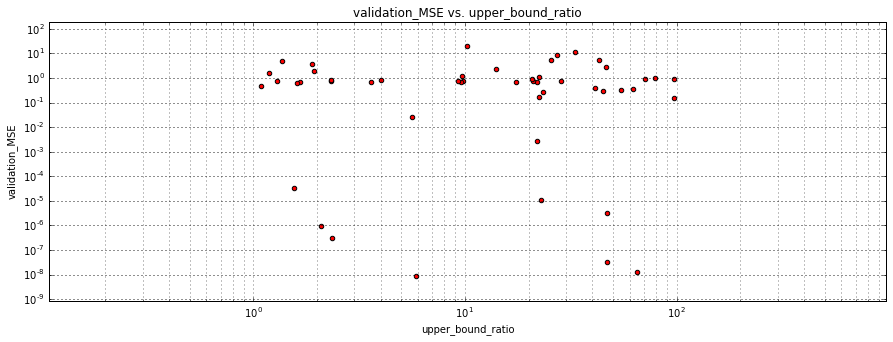

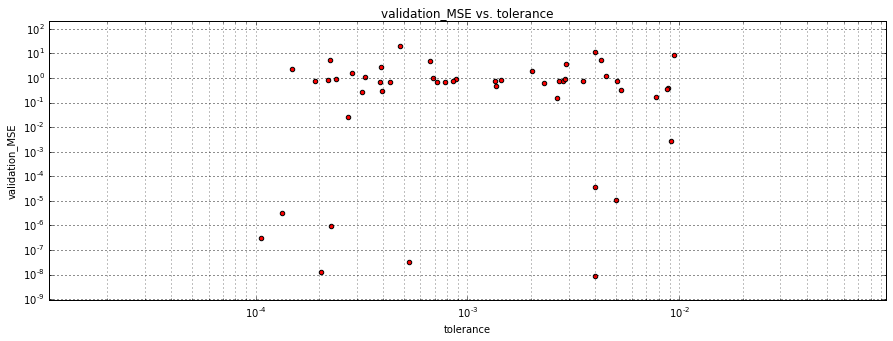

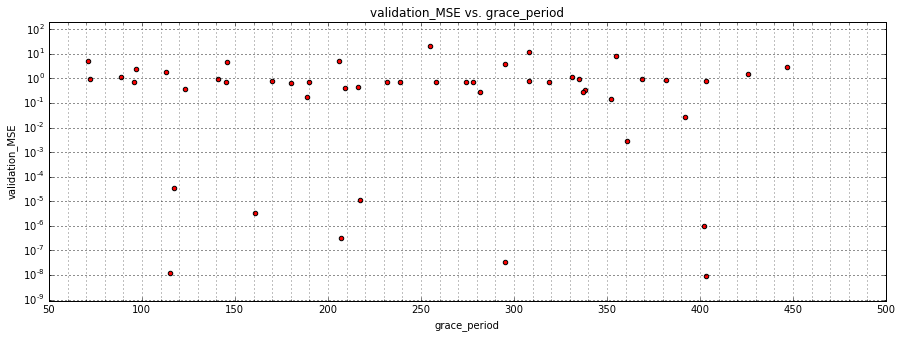

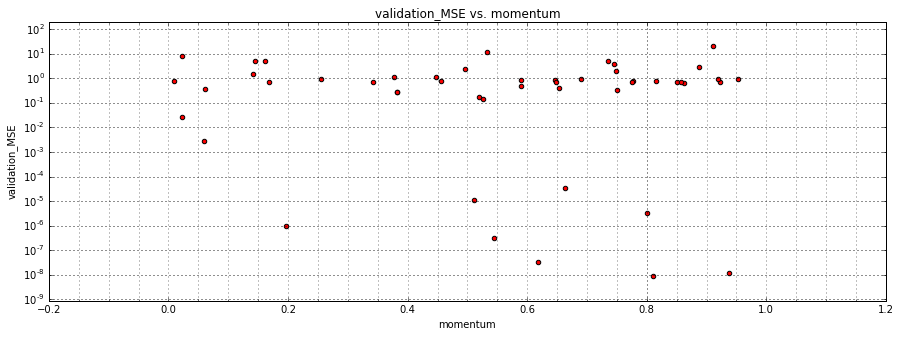

In [18]:
for hyperparam in ('l1', 'gamma', 'l2u', 'l2w', 'step_size_min', 'step_size_max', 
                   'lower_bound_ratio', 'upper_bound_ratio', 'tolerance'):
    plotMSEvsHyperParam(hyperparam)
    
for hyperparam in ('grace_period', 'momentum', ):
     plotMSEvsHyperParam(hyperparam, log=False)
                          

From the plot it appaers that the hyper-parameters related to regularization are the most influential.

For this diamond structure the L1 (Lasso) regularization strength should be less than $10^{-4}$. This constraint can also be used for the L2 (Ridge) regularization strenght of the U and W parameters. The $\gamma$ parameters appears to be optimal around $4$.